### Regime Detection

In this section we illustrate the concept of regime detection. Specifically, we look at the Hidden Markov Model (HMM). 

Hidden Markov Model (HMM):

Purpose: HMM is a more general type of probabilistic model used for modeling systems with hidden states, where the observations are influenced by the underlying hidden states.


Operation: It consists of a set of hidden states, observable states, and transition probabilities between hidden states. The emission probabilities determine the likelihood of observing a particular observation given a hidden state.


Algorithm: Similar to Gaussian HMM, the Baum-Welch algorithm is often used for training, and the Viterbi algorithm is used for decoding.


Use Case: Widely used in various applications such as speech recognition, natural language processing, bioinformatics, and finance.


 K-means clustering is focused on partitioning data into clusters based on similarity, while Gaussian HMM and HMM are probabilistic models specifically designed for handling time series data with hidden states. Gaussian HMM assumes Gaussian distributions for the hidden states, while HMM is more general and can be applied to a broader range of applications.

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from collections import Counter, deque
from imblearn.under_sampling import RandomUnderSampler

/tmp/ipykernel_4773/1569880688.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = yf.download('^GSPC', start="2017-01-01", end="2020-01-01", interval="1d")
df.head()

/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000


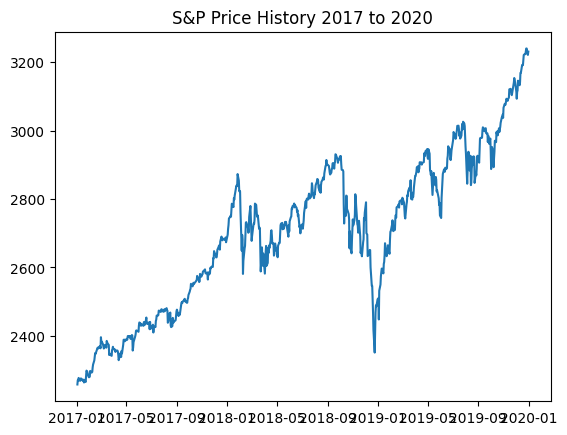

In [4]:
plt.title(f'S&P Price History 2017 to 2020')
plt.plot(
    list(i for i in df.index),
    list(i[4] for i in df.values))
plt.grid(False)

<AxesSubplot:title={'center':'Excess returns'}, xlabel='Date'>

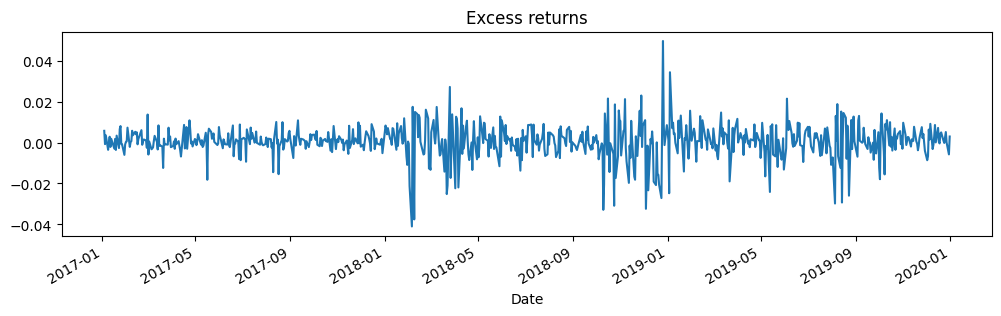

In [15]:
df['r-1'] = df['Adj Close'].pct_change().dropna()

ex_ret = df['r-1']
ex_ret.plot(title='Excess returns', figsize=(12, 3), grid=False)


In [16]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(ex_ret.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    r-1   No. Observations:                  753
Model:               MarkovRegression   Log Likelihood                2715.080
Date:                Sun, 03 Mar 2024   AIC                          -5422.161
Time:                        18:01:59   BIC                          -5403.664
Sample:                             0   HQIC                         -5415.035
                                - 753                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.155e-05    1.9e-06     11.334      0.000    1.78e-05    2.53e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.99e-05      8.861      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9854      0.007    147.207      0.000       0.972       0.999
p[1->0]        0.0394      0.016      2.420      0.016       0.007       0.071
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [6]:
res_kns.smoothed_marginal_probabilities.head()


,0,1
Date,,
2017-01-04,0.986875,0.013125
2017-01-05,0.995670,0.004330
2017-01-06,0.998204,0.001796
2017-01-09,0.999107,0.000893
2017-01-10,0.999479,0.000521


In [19]:
print(res_kns.smoothed_marginal_probabilities.head())


                   0         1
Date                          
2017-01-04  0.984180  0.015820
2017-01-05  0.993716  0.006284
2017-01-06  0.996886  0.003114
2017-01-09  0.998319  0.001681
2017-01-10  0.999059  0.000941


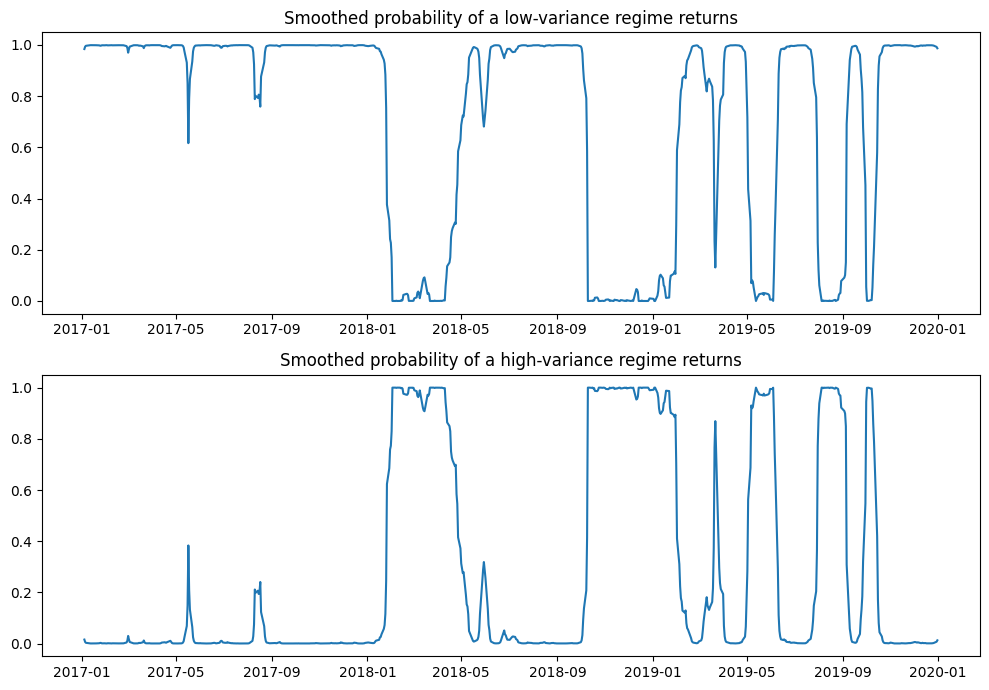

In [23]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

fig.savefig("234.pdf", bbox_inches='tight')


In [24]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [25]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

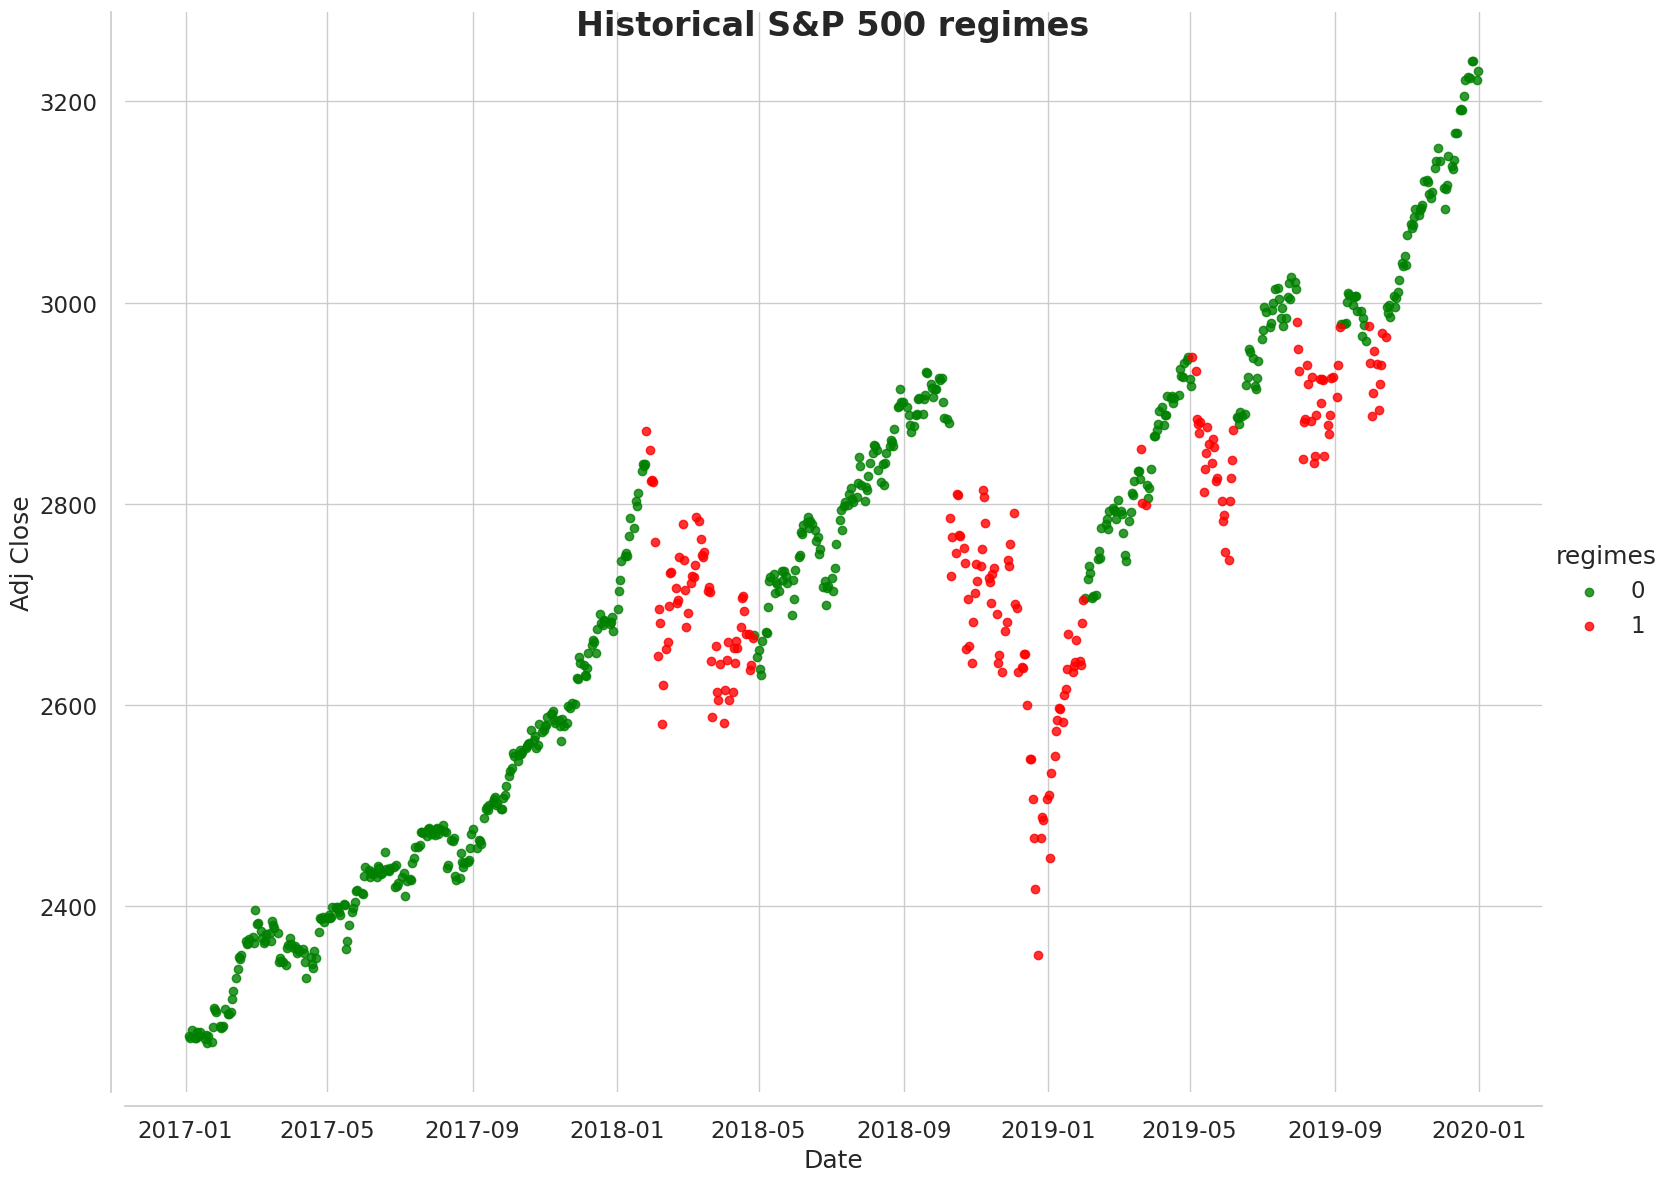

In [30]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical S&P 500 regimes', fontsize=24, fontweight='demi')
fg.savefig("Historical Regimes.pdf", bbox_inches='tight')


During periods of volatility, generally around major market decline, we see high variance regime returns (red) confirming our hypothesis. During periods of low volatility, generally during calm uptrends we see low variance regime returns (green). From an investors perspective this graph can be interpreted simply, buy or hold assets during green periods and sell holdings as soon as possible in red periods.A Markov switching regression is good at telling us what regime we were just in, ‘nowcasting’, but it doesn’t not necessarily give us much information about the next regime. A machine learning model can provide just that, giving us an expectation of the next regime.

### Utilizing KMeans 

In [1]:
# import libraries:
#
import datetime
#
from sklearn.cluster import KMeans
#
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta
import yfinance as yf

In [2]:
# get asset of interest: SP500 ticker:
asset = '^GSPC'
end_time = datetime.date.today()
# start_time = end_time - datetime.timedelta(days = 11850)
start_time = end_time - datetime.timedelta(days = 1850)
df = yf.download(asset, start=start_time, end=end_time)
df_orig = yf.download(asset, start=start_time, end=end_time)

/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [4]:
# retrieve additional features:
# S&P 500 at close prices
sp500 = yf.download('^GSPC', start=start_time, end=end_time)
df['^GSPC']=sp500['Close']
# compute ATR technical indicator
df.ta.atr(length=14, append=True)
# compute relative Volume on a rolling basis
df['relative_Vol'] = df['Volume']/df['Volume'].rolling(40).mean()
# get the daily returns of SPX500 to perform the regime detection:
df['return'] = df['Close'] - df['Close'].shift(1)

/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_9982/315354561.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


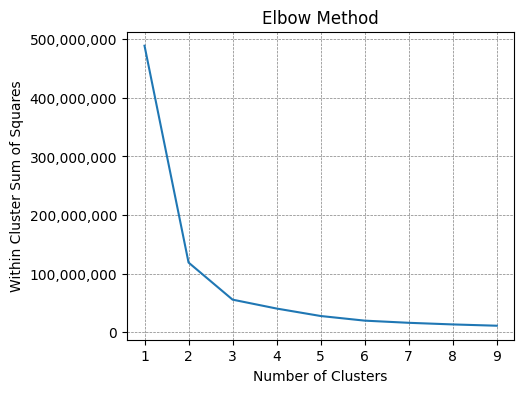

In [5]:
# Elbow method to find optimal number of regimes

df = df[['return', '^GSPC', 'ATRr_14', 'relative_Vol']]

df = df[40:]
df_orig = df_orig[40:]

#within cluster sum of squares:
wcss = []

num_clusters = list(range(1,10))

for i in num_clusters:
    kmeans=KMeans(i)
    kmeans.fit(df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
fig = plt.figure(figsize =(5, 4))
plt.plot(num_clusters,wcss)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Elbow Method')
plt.ylabel('Within Cluster Sum of Squares')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(min(num_clusters), max(num_clusters)+1, 1.0))
plt.ticklabel_format(style='plain')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([round(x) for x in current_values])
plt.show()

In [6]:
# It seems that it is optimal to choose 3 or 4 clusters/regimes so let’s go ahead with 3 clusters.
kmeans_num = 3
kmeans = KMeans(kmeans_num)
df['regime'] = kmeans.fit_predict(df)
df_orig['regime'] = df['regime']


In [7]:
print(df)


               return        ^GSPC    ATRr_14  relative_Vol  regime
Date                                                               
2019-04-12  19.089844  2907.409912  21.990422      1.024344       1
2019-04-15  -1.829834  2905.580078  21.324946      0.859383       1
2019-04-16   1.479980  2907.060059  20.878301      0.939870       1
2019-04-17  -6.610107  2900.449951  21.002857      1.009317       1
2019-04-18   4.580078  2905.030029  20.668394      0.970919       1
...               ...          ...        ...           ...     ...
2024-03-04  -6.129883  5130.950195  40.977650      1.175634       2
2024-03-05 -52.300293  5078.649902  43.345702      1.087769       2
2024-03-06  26.109863  5104.759766  43.772460      1.116779       2
2024-03-07  52.600098  5157.359863  44.993023      1.009874       2
2024-03-08 -33.669922  5123.689941  46.904934      1.022743       2

[1235 rows x 5 columns]


In [8]:
print(df_orig)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-04-12  2900.860107  2910.540039  2898.370117  2907.409912  2907.409912   
2019-04-15  2908.320068  2909.600098  2896.479980  2905.580078  2905.580078   
2019-04-16  2912.260010  2916.060059  2900.709961  2907.060059  2907.060059   
2019-04-17  2916.040039  2918.000000  2895.449951  2900.449951  2900.449951   
2019-04-18  2904.810059  2908.399902  2891.899902  2905.030029  2905.030029   
...                 ...          ...          ...          ...          ...   
2024-03-04  5130.990234  5149.669922  5127.180176  5130.950195  5130.950195   
2024-03-05  5110.520020  5114.540039  5056.819824  5078.649902  5078.649902   
2024-03-06  5108.029785  5127.970215  5092.220215  5104.759766  5104.759766   
2024-03-07  5132.379883  5165.620117  5128.209961  5157.359863  5157.359863   
2024-03-08  5164.459961  5189.259766  5117.500000  5

/tmp/ipykernel_9982/3629409398.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


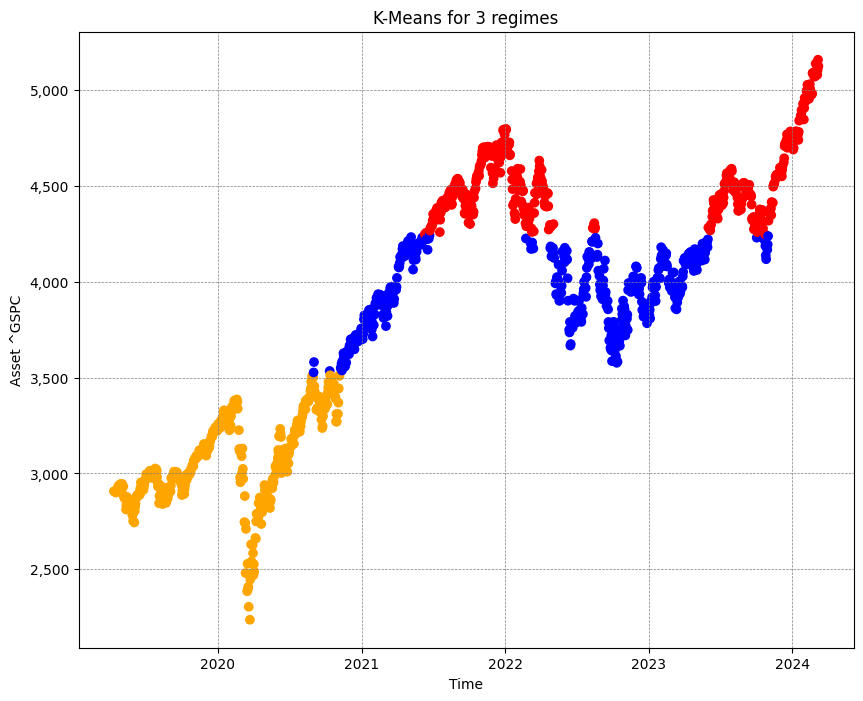

In [9]:
# Plot regimes

colours = []
vcs = {v: i for i, v in enumerate(df_orig.regime.value_counts().index)}
df_orig['freq_rank'] = df_orig.regime.apply(vcs.get)

for i in range(0,len(df_orig)):
    if df_orig['freq_rank'].iloc[i]==0:
        colours.append('blue')
    elif df_orig['freq_rank'].iloc[i]==1:
        colours.append('red')
    elif df_orig['freq_rank'].iloc[i]==2:
        colours.append('orange')
    else:
        colours.append('brown')
        
fig = plt.figure(figsize =(10, 8))
plt.scatter(df_orig.index, df_orig.Close, c=colours)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title(f'K-Means for {kmeans_num} regimes')
plt.ylabel(f'Asset {asset}')
plt.xlabel('Time')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

#### Regime analysis of FTSE 100

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from collections import Counter, deque
from imblearn.under_sampling import RandomUnderSampler

/tmp/ipykernel_1371/1569880688.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = yf.download('^FTSE', start="2017-01-01", end="2020-01-01", interval="1d")
df.head()

/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,7142.799805,7205.500000,7142.799805,7177.899902,7177.899902,795658400
2017-01-04,7177.899902,7189.700195,7168.799805,7189.700195,7189.700195,742050400
2017-01-05,7189.700195,7212.000000,7172.799805,7195.299805,7195.299805,768721000
2017-01-06,7195.299805,7210.100098,7180.600098,7210.100098,7210.100098,694323700
2017-01-09,7210.100098,7243.799805,7207.399902,7237.799805,7237.799805,705536400


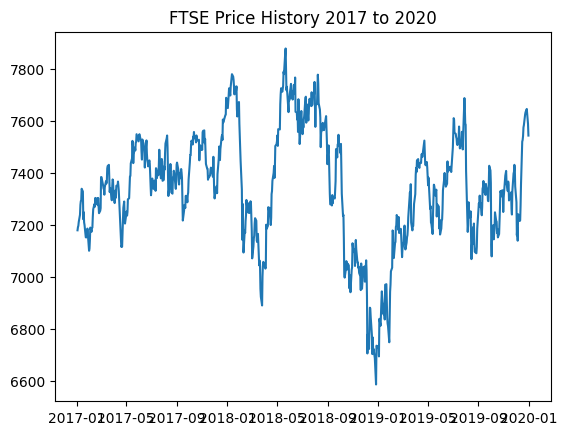

In [4]:
plt.title(f'FTSE Price History 2017 to 2020')
plt.plot(
    list(i for i in df.index),
    list(i[4] for i in df.values))
plt.grid(False)

<Axes: title={'center': 'Excess returns'}, xlabel='Date'>

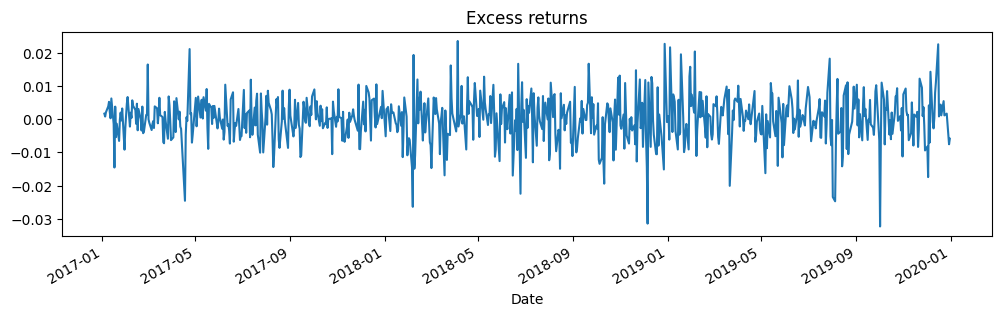

In [5]:
df['r-1'] = df['Adj Close'].pct_change().dropna()

ex_ret = df['r-1']
ex_ret.plot(title='Excess returns', figsize=(12, 3), grid=False)

In [6]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(ex_ret.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    r-1   No. Observations:                  757
Model:               MarkovRegression   Log Likelihood                2712.171
Date:                Mon, 26 Feb 2024   AIC                          -5416.343
Time:                        17:33:40   BIC                          -5397.825
Sample:                             0   HQIC                         -5409.211
                                - 757                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.882e-05    2.8e-06     10.303      0.000    2.33e-05    3.43e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   1.69e-05      6.320      0.000    7.39e-05       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9619      0.018     52.585      0.000       0.926       0.998
p[1->0]        0.1095      0.047      2.323      0.020       0.017       0.202
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [7]:
res_kns.smoothed_marginal_probabilities.head()


,0,1
Date,,
2017-01-04,0.956107,0.043893
2017-01-05,0.970896,0.029104
2017-01-06,0.976082,0.023918
2017-01-09,0.975653,0.024347
2017-01-10,0.972539,0.027461


In [8]:
print(res_kns.smoothed_marginal_probabilities.head())

                   0         1
Date                          
2017-01-04  0.956107  0.043893
2017-01-05  0.970896  0.029104
2017-01-06  0.976082  0.023918
2017-01-09  0.975653  0.024347
2017-01-10  0.972539  0.027461


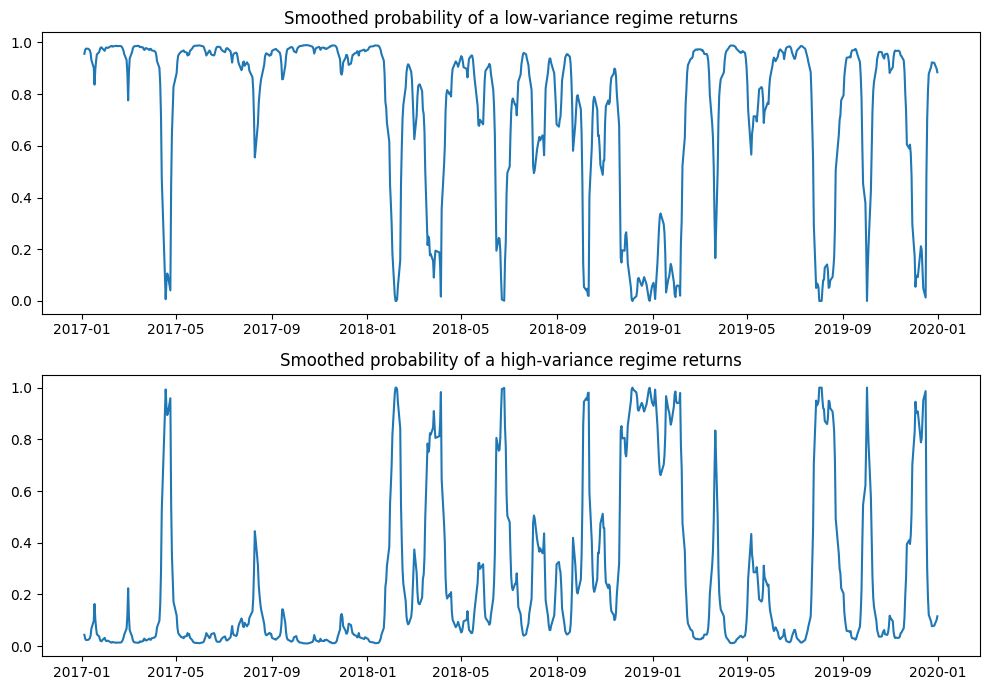

In [9]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

In [10]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [11]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [12]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

Text(0.5, 0.98, 'Historical FTSE 100 regimes')

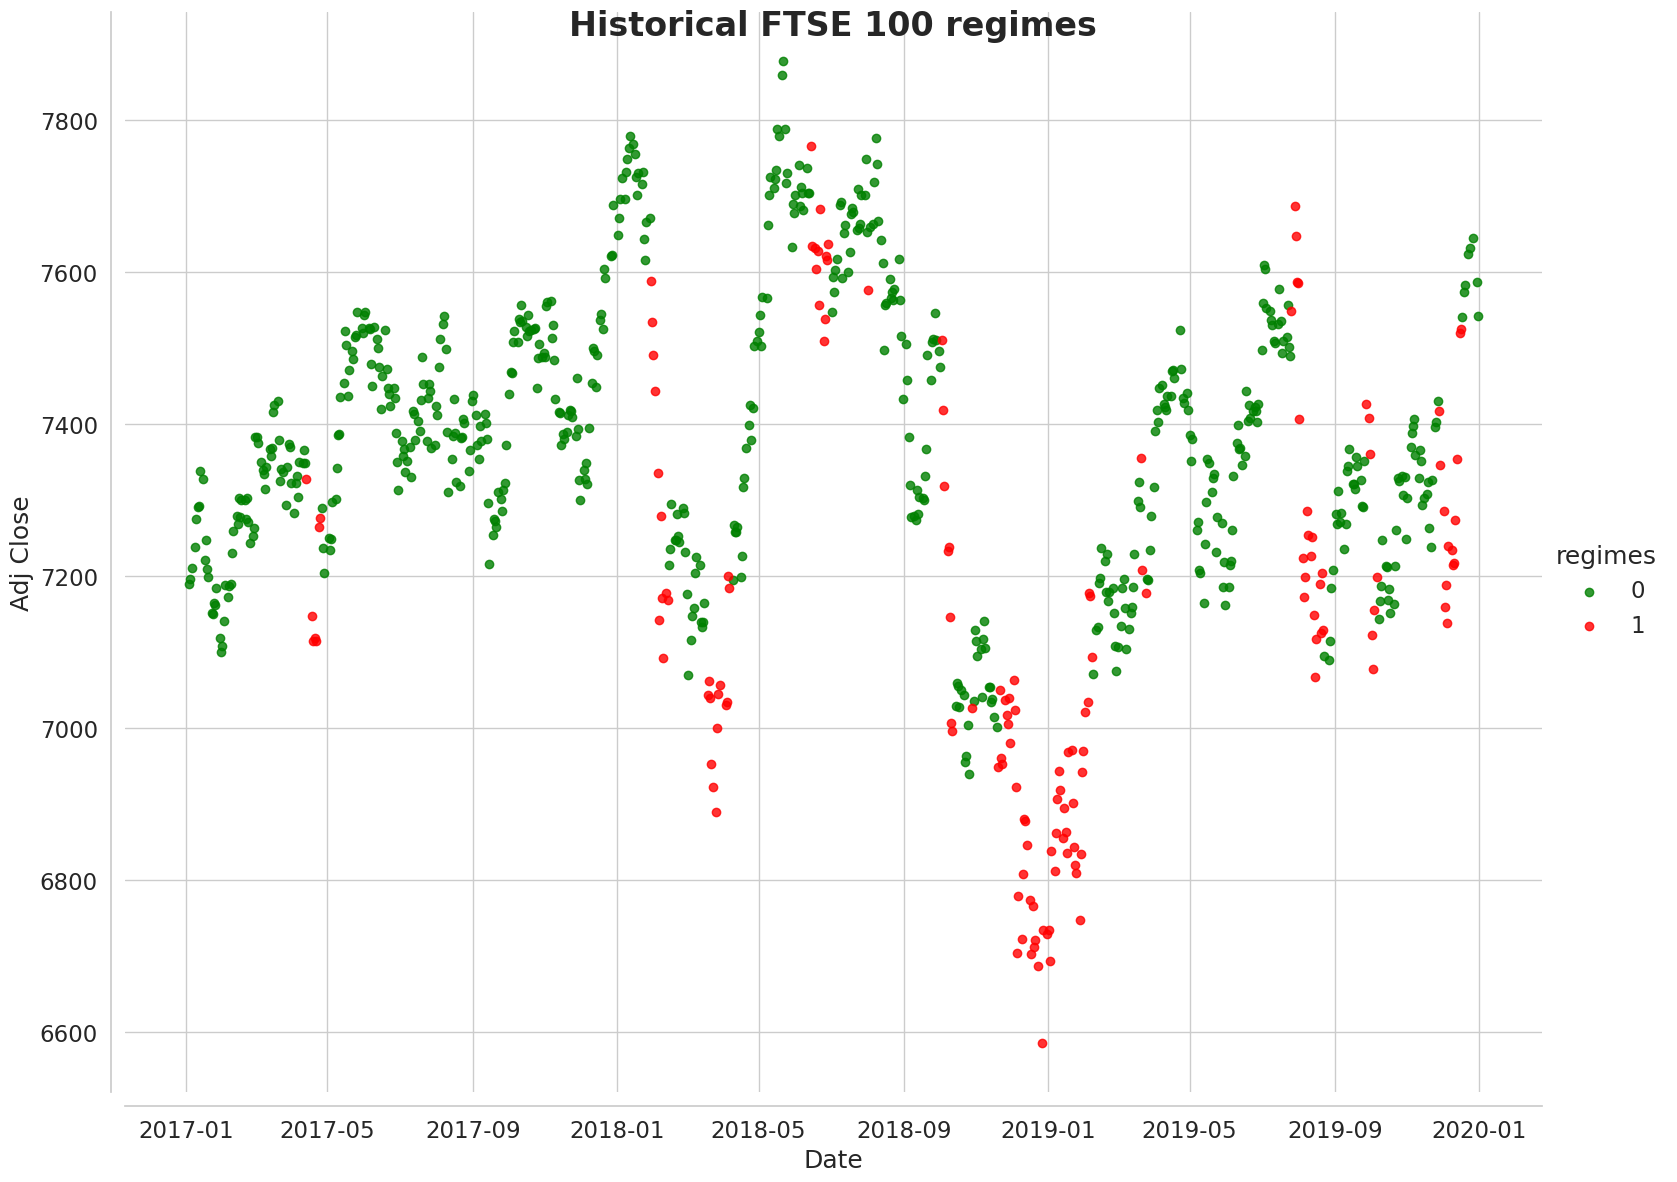

In [13]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical FTSE 100 regimes', fontsize=24, fontweight='demi')